In [1]:
%matplotlib inline


# Imputing missing values with variants of IterativeImputer


The :class:`sklearn.impute.IterativeImputer` class is very flexible - it can be
used with a variety of estimators to do round-robin regression, treating every
variable as an output in turn.

In this example we compare some estimators for the purpose of missing feature
imputation with :class:`sklearn.impute.IterativeImputer`:

* :class:`~sklearn.linear_model.BayesianRidge`: regularized linear regression
* :class:`~sklearn.tree.DecisionTreeRegressor`: non-linear regression
* :class:`~sklearn.ensemble.ExtraTreesRegressor`: similar to missForest in R
* :class:`~sklearn.neighbors.KNeighborsRegressor`: comparable to other KNN
  imputation approaches

Of particular interest is the ability of
:class:`sklearn.impute.IterativeImputer` to mimic the behavior of missForest, a
popular imputation package for R. In this example, we have chosen to use
:class:`sklearn.ensemble.ExtraTreesRegressor` instead of
:class:`sklearn.ensemble.RandomForestRegressor` (as in missForest) due to its
increased speed.

Note that :class:`sklearn.neighbors.KNeighborsRegressor` is different from KNN
imputation, which learns from samples with missing values by using a distance
metric that accounts for missing values, rather than imputing them.

The goal is to compare different estimators to see which one is best for the
:class:`sklearn.impute.IterativeImputer` when using a
:class:`sklearn.linear_model.BayesianRidge` estimator on the California housing
dataset with a single value randomly removed from each row.

For this particular pattern of missing values we see that
:class:`sklearn.ensemble.ExtraTreesRegressor` and
:class:`sklearn.linear_model.BayesianRidge` give the best results.



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.experimental import enable_iterative_imputer 
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [8]:
N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

In [13]:
# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

[6 7 1 ... 0 0 1] 8 2064


In [10]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

C:\Users\KindYAK\Anaconda3\envs\def\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\KindYAK\Anaconda3\envs\def\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\KindYAK\Anaconda3\envs\def\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\KindYAK\Anaconda3\envs\def\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\KindYAK\Anaconda3\envs\def\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


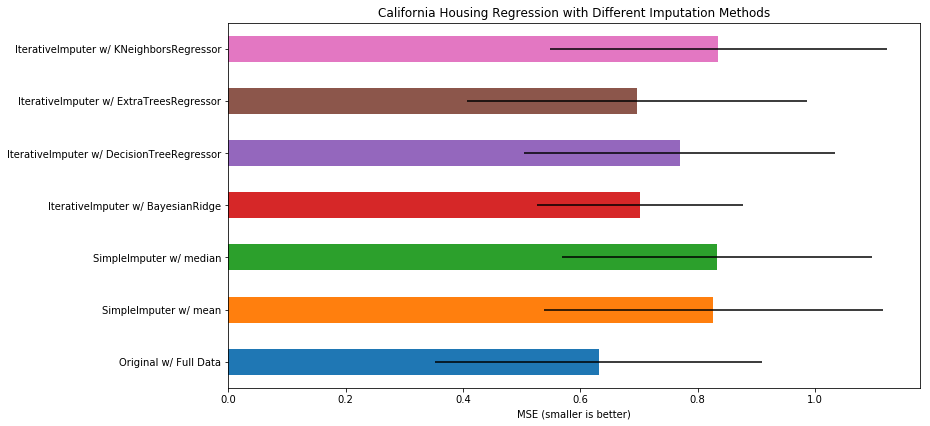

In [11]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

# plot boston results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.get_values()])
plt.tight_layout(pad=1)
plt.show()